In [1]:
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

Load geo data from Wikipedia using pandas read_html function.

In [2]:
toronto_raw = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
toronto_raw

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


In [3]:
# Remove the neighborhood taht has 'Not assigned' borough
toronto_neigh = toronto_raw[toronto_raw['Borough'] != 'Not assigned'].reset_index()

# If the neighborhood has the 'Not assigned' value, take the value from borough
condition = toronto_neigh['Neighborhood'] == 'Not assigned'
toronto_neigh[toronto_neigh[condition]]['Neighborhood'] = toronto_neigh[toronto_neigh[condition]]['Borough']

toronto_neigh

,index,Postal Code,Borough,Neighborhood
0,2,M3A,North York,Parkwoods
1,3,M4A,North York,Victoria Village
2,4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,5,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...,...
98,160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,165,M4Y,Downtown Toronto,Church and Wellesley
100,168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


Get coordinates data from cocl.us site.

In [4]:
neigh_coor = pd.read_csv('http://cocl.us/Geospatial_data')
neigh_coor

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


Join the coordinates table with the Toronto neighborhood table based on the postal code.

In [5]:
toronto_neigh = toronto_neigh.merge(neigh_coor, how='left', left_on='Postal Code', right_on='Postal Code', suffixes=('','_coor'))
toronto_neigh.drop(columns='index', inplace=True)

toronto_neigh

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


Since the postal code and neighborhood features play unimportant role in clustering, we remove it from the final dataframe.

We also do one-hot encoding of the 'Borough' column. Then add the new encoded columns to the final dataframe and remove the 'Borough' column as it is no longer needed.

In [6]:
toronto_simplified = toronto_neigh.drop(columns=['Postal Code', 'Neighborhood'])
borough_onehot = pd.get_dummies(toronto_simplified[['Borough']], prefix='', prefix_sep='')
toronto_final = pd.concat([toronto_simplified, borough_onehot], axis=1).drop(columns='Borough')

toronto_final

,Latitude,Longitude,Central Toronto,Downtown Toronto,East Toronto,East York,Etobicoke,Mississauga,North York,Scarborough,West Toronto,York
0,43.753259,-79.329656,0,0,0,0,0,0,1,0,0,0
1,43.725882,-79.315572,0,0,0,0,0,0,1,0,0,0
2,43.654260,-79.360636,0,1,0,0,0,0,0,0,0,0
3,43.718518,-79.464763,0,0,0,0,0,0,1,0,0,0
4,43.662301,-79.389494,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
98,43.653654,-79.506944,0,0,0,0,1,0,0,0,0,0
99,43.665860,-79.383160,0,1,0,0,0,0,0,0,0,0
100,43.662744,-79.321558,0,0,1,0,0,0,0,0,0,0
101,43.636258,-79.498509,0,0,0,0,1,0,0,0,0,0


We identify the optimal number of clusters using the Elbow method.

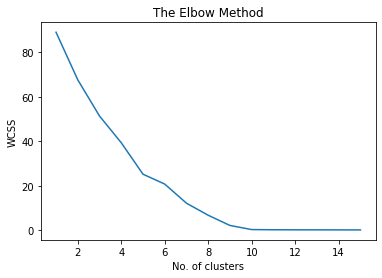

In [7]:
wcss = []
max_k = 15

for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(toronto_final)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, max_k + 1), wcss)
plt.title('The Elbow Method')
plt.xlabel('No. of clusters')
plt.ylabel('WCSS')
plt.show()

From the graph above, we can see that k=9 seems to be a good hyperparameter in this classification model.

Thus, we build the model again using k=9 and add the labels to the full Toronto neighborhood dataframe.

In [8]:
opt_k = 9

opt_kmeans = KMeans(n_clusters=opt_k, init='k-means++', max_iter=300, n_init=10, random_state=0)
opt_kmeans.fit(toronto_final)
labels = opt_kmeans.labels_

toronto_neigh['Label'] = labels
toronto_neigh

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Label
0,M3A,North York,Parkwoods,43.753259,-79.329656,1
1,M4A,North York,Victoria Village,43.725882,-79.315572,1
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0
...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,2
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,0
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,6
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,2


Display the clustered neighborhood on a map using CircleMarker from folium library.

In [9]:
# calculate average latitude and Longitude
avg_lat = toronto_neigh['Latitude'].mean()
avg_long = toronto_neigh['Longitude'].mean()

# set color scheme for the clusters
x = np.arange(opt_k)
ys = [i + x + (i*x)**2 for i in range(opt_k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# create map
map_clusters = folium.Map(location=[avg_lat, avg_long], zoom_start=10)

# add markets to the map
markers_colors = []
for lat, long, neigh, cluster in zip(toronto_neigh['Latitude'], toronto_neigh['Longitude'], toronto_neigh['Neighborhood'], toronto_neigh['Label']):
    label = folium.Popup(f'{neigh} Cluster {cluster}', parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_opacity=0.7
    ).add_to(map_clusters)

map_clusters